In [1]:
%matplotlib inline
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal # Gaussian multivariate

data = np.genfromtxt('EMGaussian.data', delimiter=' ')

A = np.ones((4,4)) * 1/6 + np.identity(4) * 1/3

pi = np.array([1/4] * 4)
mu =  np.array([[-3.06196072, -3.53454048],
 [ 3.80070949, -3.7972974 ],
 [ 3.97793026,  3.77333066],
 [-2.03436695,  4.17258596]])

sigma = np.array([np.array([[ 6.24140911,  6.05017465],
       [ 6.05017465,  6.1824553 ]]), np.array([[ 0.92127926,  0.0573808 ],
       [ 0.0573808 ,  1.86586022]]), np.array([[  0.21035667,   0.29045083],
       [  0.29045083,  12.23996576]]), np.array([[ 2.90442381,  0.20655763],
       [ 0.20655763,  2.75617077]])])

In [2]:
# logarithm for alphaRecursion, otherwise the probability will be 0...
# + use max (see formula p8.1)
def logalphaRecursion(data, A, pi, mu, sigma):
    K = len(pi) # number of classes
    T, _ = data.shape
    # alpha contains 4 values (for each class) at each time
    alpha = np.zeros((T, K))
    
    # compute alpha for the initial state
    # and compute multivariate for K classes and all the data
    N = np.zeros((K, T))
    for k in range(K):
        N[k] = multivariate_normal.pdf(data, mean=mu[k], cov=sigma[k], allow_singular=True)    
    alpha[0] = np.log(pi) + np.log(N[:, 0])
    
    for t in range(1, T):
        pa = np.log(A) + alpha[t-1, :]
        alpha[t] = np.log(N[:,t]) + np.max(pa, axis=1) + np.log(np.sum(np.exp(pa - np.max(pa, axis=1)[:, np.newaxis]), axis=1))
    
    return alpha

In [3]:
# execution time = x60 faster w.r.t naive coding
start_time = time.time()
myLogAlpha = logalphaRecursion(data, A, pi, mu, sigma)
elapsed_time = time.time() - start_time
print("elapsed time: ", elapsed_time, "s")
myLogAlpha

elapsed time:  0.19121980667114258 s


array([[   -4.97190381,   -12.31015441,   -26.05782722,    -9.2305441 ],
       [ -156.51195469,   -62.45262574,  -115.73665022,   -10.83523937],
       [  -53.90025878,   -54.32148523,   -15.96218114,   -23.9760261 ],
       ..., 
       [-2291.73759047, -2303.37669043, -2326.81571412, -2296.1812004 ],
       [-2296.7267847 , -2359.00958053, -2578.61458335, -2319.89565816],
       [-2299.89239803, -2318.47457703, -2378.1319458 , -2308.24354772]])

In [4]:
def logbetaRecursion(data, A, pi, mu, sigma):
    K = len(pi) # number of classes
    T, _ = data.shape
    # alpha contains 4 values (for each class) at each time
    beta = np.zeros((T, K))
    
    # compute beta for the initial state
    # useless np.log(1) = 0
    beta[T-1, :] = np.log(np.ones((1,K)))
    
    # initialize multivariate gaussian
    N = np.zeros((K, T))
    for k in range(K):
        N[k] = multivariate_normal.pdf(data, mean=mu[k], cov=sigma[k], allow_singular=True)
    
    for t in range(T-2, -1, -1):
        pa = np.log(A).T + np.log(N[:, t+1]) + beta[t+1, :]
        beta[t] = np.max(pa, axis=1) + np.log(np.sum(np.exp(pa - np.max(pa, axis=1)[:, np.newaxis]), axis=1))
        
    return beta

In [5]:
# execution time = x100 faster w.r.t naive coding
start_time = time.time()
myLogBeta = logbetaRecursion(data, A, pi, mu, sigma)
elapsed_time = time.time() - start_time
print("elapsed time: ", elapsed_time, "s")
myLogBeta

elapsed time:  0.014533042907714844 s


array([[-2294.96243095, -2294.96243095, -2294.96243095, -2293.86381866],
       [-2289.05714611, -2289.05714611, -2287.95860836, -2289.05692255],
       [-2282.83632152, -2283.93031474, -2283.93031615, -2283.91659113],
       ..., 
       [   -8.15848454,    -9.25709683,    -9.25709683,    -9.25709682],
       [   -3.16537722,    -4.26351741,    -4.26351746,    -4.26210272],
       [    0.        ,     0.        ,     0.        ,     0.        ]])

## Question 2

In [6]:
# compute p(q_t | u_1, ..., u_T), we name this function smoothing (see 7.12)
# alpha and beta used here are actually logAlpha and logBeta
def smoothing(alpha, beta):
    # max loglikelihood of each class whatever the time t
    maxi = np.amax(alpha + beta, axis=0)
    
    # pointwise summation of the columns (axis = 1)
    logsum = np.log(np.sum(np.exp(alpha + beta - maxi), axis=1))
    return np.exp(alpha + beta - maxi[np.newaxis, :] - logsum[:, np.newaxis])

In [7]:
# test should sum to 1 when summation is done over the column (test correctness)
smoothingProba = smoothing(myLogAlpha, myLogBeta)
#np.sum(smoothingProba, axis=1)

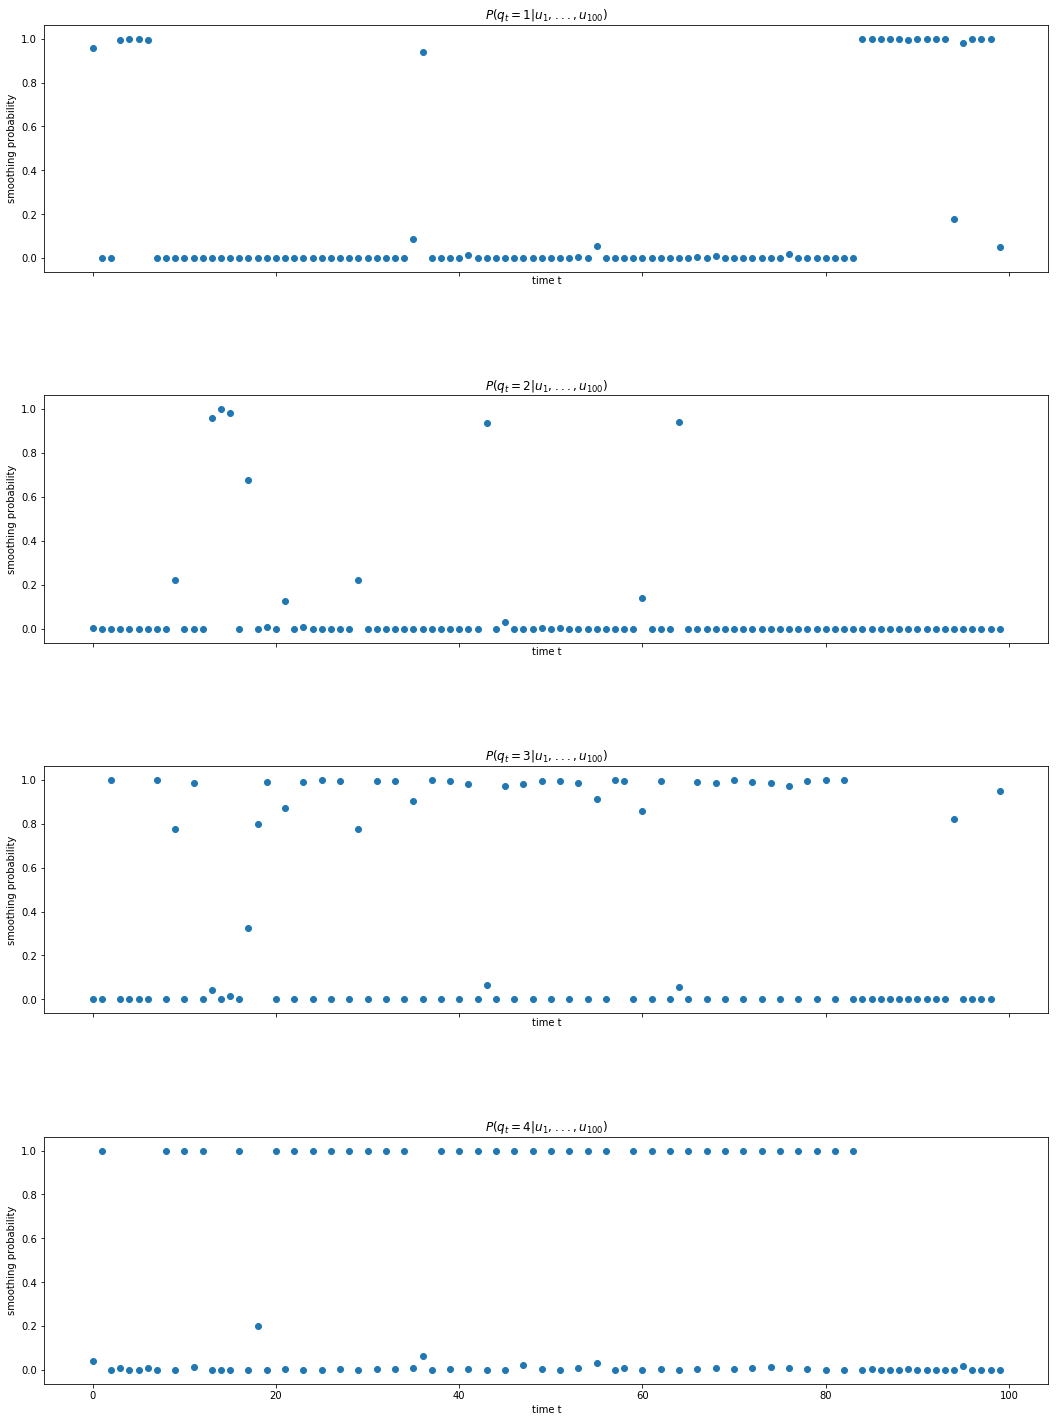

In [8]:
T, d = 100, smoothingProba.shape[1];
f, ax = plt.subplots(d, 1, sharex=True, figsize=(18,25))
f.subplots_adjust(hspace=.5)
for i in range(d):
    ax[i].scatter(np.arange(T), smoothingProba[:T, i])
    ax[i].set_xlabel("time t")
    ax[i].set_ylabel("smoothing probability")
    ax[i].set_title(r'$P(q_t = %d|u_1, ..., u_{100})$' % (i+1))

## Question 3

See the report for the estimation of the EM algorithm

## Question 4

EM algorithm to learn the parameters of the model

In [9]:
def joint_proba(alpha, beta, data, mu, sigma, A):
    (T, K) = alpha.shape
    
    # need to store p[qt+1 = i, qt = j | uo,... uT] for all i, j in {1,...,K} and all t in 0 T-1
    result = np.zeros((T-1, K,K))
    
    # compute - log(p[uO, ... uT])
    pa = (alpha + beta)[0, :]
    logsum = np.log(np.sum(np.exp(pa - np.max(pa))))
    term1 = np.max(pa) + logsum
    
    result -= term1
    
    # initialize multivariate gaussian
    N = np.zeros((K, T))
    for k in range(K):
        N[k] = multivariate_normal.pdf(data, mean=mu[k], cov=sigma[k], allow_singular=True)
    
    for t in range(T-1):
        result[t, :] += ((np.log(N[:, t+1]) + beta[t+1, :]) + np.log(A).T).T + alpha[t]
        
    return np.exp(result)
        
# verify correctness. We should have 1 everywhere as 
# sum_ij(p[qt+1 = i, qt = j | u0, ..., uT]) = [1, ..., 1]
test = joint_proba(myLogAlpha, myLogBeta, data, mu, sigma, A)
#np.sum(test, axis=(1,2))

In [10]:
# execution time = x40 faster w.r.t naive coding
start_time = time.time()
joint_proba(myLogAlpha, myLogBeta, data, mu, sigma, A)
elapsed_time = time.time() - start_time
print("elapsed time: ", elapsed_time, "s")

elapsed time:  0.004008293151855469 s


In [11]:
from scipy.stats import multivariate_normal

A = np.ones((4,4)) * 1/6 + np.identity(4) * 1/3

pi = np.array([1/4] * 4)
mu =  np.array([[-3.06196072, -3.53454048],
 [ 3.80070949, -3.7972974 ],
 [ 3.97793026,  3.77333066],
 [-2.03436695,  4.17258596]])

sigma = np.array([np.array([[ 6.24140911,  6.05017465],
       [ 6.05017465,  6.1824553 ]]), np.array([[ 0.92127926,  0.0573808 ],
       [ 0.0573808 ,  1.86586022]]), np.array([[  0.21035667,   0.29045083],
       [  0.29045083,  12.23996576]]), np.array([[ 2.90442381,  0.20655763],
       [ 0.20655763,  2.75617077]])])

def compute_log_likelihood(logbeta, logalpha):
    # We take for example q_0 to compute the probability by marginalization
    a = (logalpha + logbeta)[0, :]
    maxi = np.max(a)
    logsum = np.log(np.sum(np.exp(a - maxi)))
    log_likelihood = maxi + logsum
    return log_likelihood

# the parameters are passed as arguments to the em function
# these parameters are initialized by the previous gaussian mixture
# algorithm
def em(data, A, pi, mu, sigma, iter=100, tol=10e-6, verbose=False):
    sigma_ = np.copy(sigma)
    K = len(pi)
    (T, d) = data.shape
    
    log_likelihood = []
    
    for k in range(iter):
        
        # E step. We need to compute
        # P[qt = i | u1, ..., uT]
        # P[qt+1 = i, qt = i | u1, ..., uT]        
        alpha = logalphaRecursion(data, A, pi, mu, sigma_)
        beta = logbetaRecursion(data, A, pi, mu, sigma_)
        
        # smoothing function compute P[qt = i | u1, ..., uT]
        P_q = smoothing(alpha, beta)
        
        # joint probability P_qq: P[qt+1 = j, qt = i | u1, ..., uT]
        P_qq = joint_proba(alpha, beta, data, mu, sigma_, A)
        
        log_likelihood.append(compute_log_likelihood(beta, alpha))
        
        # stopping criterion
        if len(log_likelihood) >= 2 and np.abs(log_likelihood[-1] - log_likelihood[-2]) < tol:
            break
        
        if verbose and len(log_likelihood) >= 2:
            print(np.abs(log_likelihood[-1] - log_likelihood[-2]))
        
        # M step
        # pi = P[q0 = i | u1, ..., uT]
        pi = P_q[0]
        
        # compute parameter A efficiently
        A = np.sum(P_qq, axis=0) / np.sum(P_qq, axis=(0,2))
        
        # compute mu efficiently
        mu = (P_q[:,:, np.newaxis].T.dot(data) / np.sum(P_q, axis=0)[:, np.newaxis]).reshape(4, 2)
        
        for i in range(K):                
            # compute \Sigma_{1}, \Sigma_{2}, \Sigma_{3}, \Sigma_{4}            
            center_data = data - mu[i]
            
            # np.einsum('ij,ik->ijk',center_data,center_data)            
            sigma_[i] = np.einsum('ij,ik, i->jk', center_data, center_data, P_q[:, i]) / np.sum(P_q[:,i])
        
    return A, pi, mu, sigma_, np.array(log_likelihood)

In [12]:
A_after, pi_after, mu_after, sigma_after, log_likelihood = em(data, A, pi, mu, sigma)
print(A_after, pi_after, mu_after, sigma_after)

[[ 0.90067646  0.03420608  0.03264011  0.06301856]
 [ 0.02011108  0.87859385  0.01208935  0.04635892]
 [ 0.07245627  0.04762161  0.02247303  0.8748577 ]
 [ 0.00675623  0.03957846  0.93279751  0.01576478]] [  1.00000000e+00   6.71876146e-29   2.02171545e-80   1.95713685e-15] [[-2.96885014 -3.4459645 ]
 [ 3.7891398  -3.97496603]
 [ 3.99448621  3.63334636]
 [-1.95006897  4.19405144]] [[[  6.80921539   6.58540288]
  [  6.58540288   6.68647232]]

 [[  0.94421914   0.06116546]
  [  0.06116546   1.55352511]]

 [[  0.19771204   0.25882982]
  [  0.25882982  12.34155271]]

 [[  3.28395957   0.30483669]
  [  0.30483669   2.83135903]]]


## Question 5
Plot log-likelihood on the train data and on the test data as a function of the number of iterations

In [13]:
dataTrain = np.genfromtxt('EMGaussian.data', delimiter=' ')
A_train, pi_train, mu_train, sigma_train, log_likelihood_train = em(dataTrain, A, pi, mu, sigma)

Text(0.5,1,'final training log-likelihood value: -1896.79')

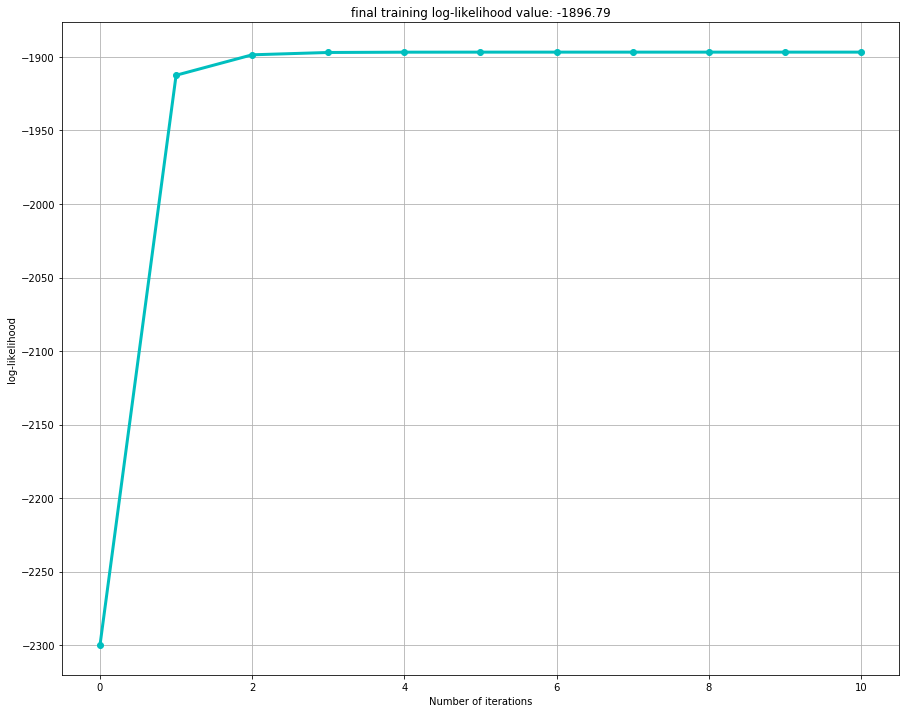

In [14]:
plt.figure(figsize=(15,12))
plt.grid(True)
plt.plot(log_likelihood_train, 'co-', linewidth=3)
plt.xticks(np.arange(0, len(log_likelihood_train), 2))
plt.xlabel("Number of iterations")
plt.ylabel("log-likelihood")
plt.title("final training log-likelihood value: %.2f" % log_likelihood_train[-1])

In [15]:
dataTest = np.genfromtxt('EMGaussian.test', delimiter=' ')
A_test, pi_test, mu_test, sigma_test, log_likelihood_test = em(dataTest, A, pi, mu, sigma)

C:\Users\victo\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Text(0.5,1,'final testing log-likelihood value: -1916.40')

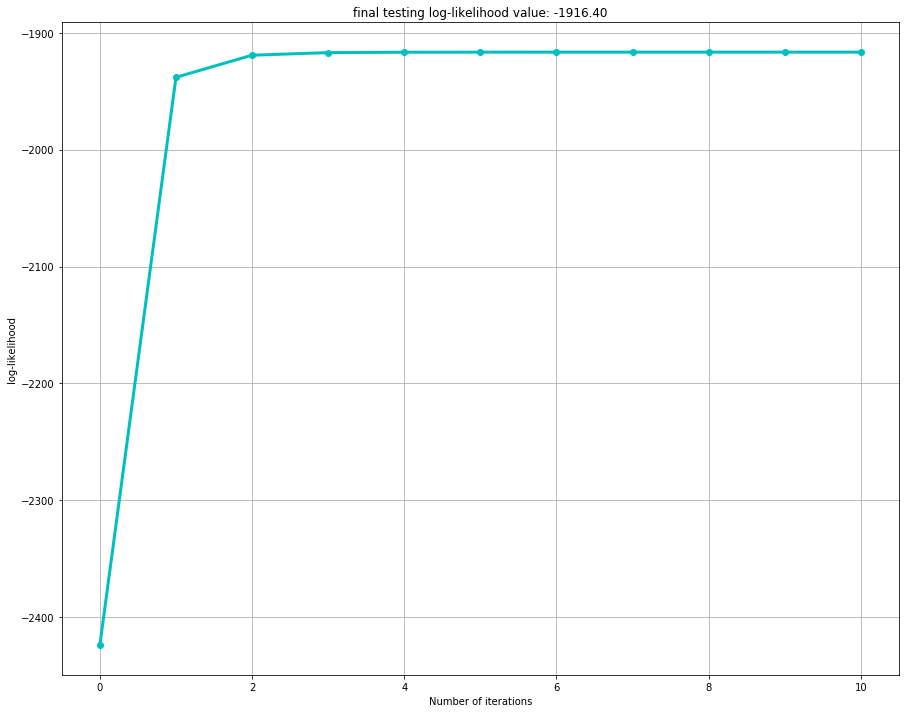

In [16]:
plt.figure(figsize=(15,12))
plt.grid(True)
plt.xticks(np.arange(0, len(log_likelihood_train), 2))
plt.plot(log_likelihood_test, 'co-', linewidth=3)
plt.xlabel("Number of iterations")
plt.ylabel("log-likelihood")
plt.title("final testing log-likelihood value: %.2f" % log_likelihood_test[-1])

## Question 6

|             	| Gaussian mixture model 	| Hidden Markov model 	|
|-------------	|------------------------	|---------------------	|
| Train set   	| -2327.72               	| -1896.79          	|
| testing set 	| -2408.97               	| -1916.40            	|

Hidden Markov model performs better at modelling the data. This is because an HMM is a series of GMM.

## Question 8

In [30]:
def viterbi(data, A, pi, mu, sigma):
    K = len(pi)
    T, d = data.shape
    
    M = np.zeros((T, K))
    S = np.zeros((T,K))
    
    N = np.zeros((T, K))
    for k in range(K):
        # initialize multivariate gaussian distribution 
        N[:, k] = multivariate_normal.pdf(data, mean=mu[k], cov=sigma[k])
        
        # initialize algorithm
        M[0, k] = np.log(pi[k]) + np.log(N[0, k])
        S[0, k] = 0
        
    # recursion
    for t in range(1, T):
        M[t] = np.log(N[t, :]) + np.max(np.log(A) + M[t-1, :], axis=1)
        S[t] = np.argmax(np.log(A) + M[t-1, :], axis=1)
    
    # return the most likely state for each step
    q = np.zeros(T, dtype=int)
    q[T-1] = np.argmax(M[T-1, :])
    
    for t in range(T-2, -1, -1):
        q[t] = S[t+1, q[t+1]]
        
    return q

In [31]:
start_time = time.time()
q_vit = viterbi(data, A, pi, mu, sigma)
elapsed_time = time.time() - start_time
print("elapsed time: ", elapsed_time, "s")

elapsed time:  0.009500265121459961 s


In [32]:
def plot_viterbi(data, mu, q):
    K, _ = mu.shape
    plt.figure(figsize=(15,12))
    plt.title('Final centroids and clusters using Viterbi algorithm')
    cm = plt.cm.get_cmap('nipy_spectral')
    colors = cm([k/K for k in range(K)])
    for k, c in zip(range(K), colors):
        plt.scatter(data[q == k, 0], data[q == k, 1], color=c, marker='o', s=40)
        plt.scatter(mu[:,0], mu[:,1], color="red", marker="^", s=200)


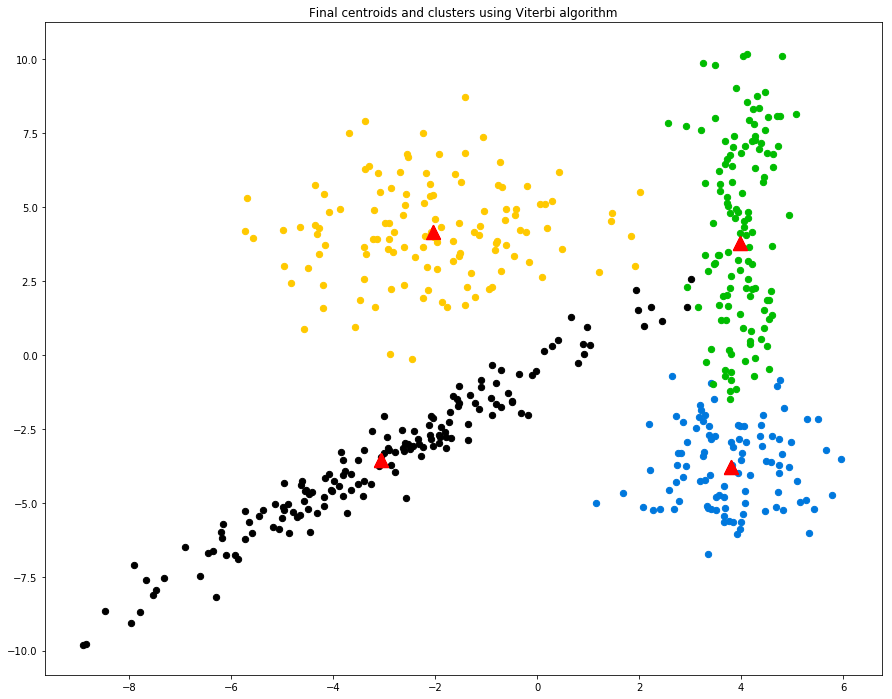

In [33]:
plot_viterbi(data, mu, q_vit)

## Question 9

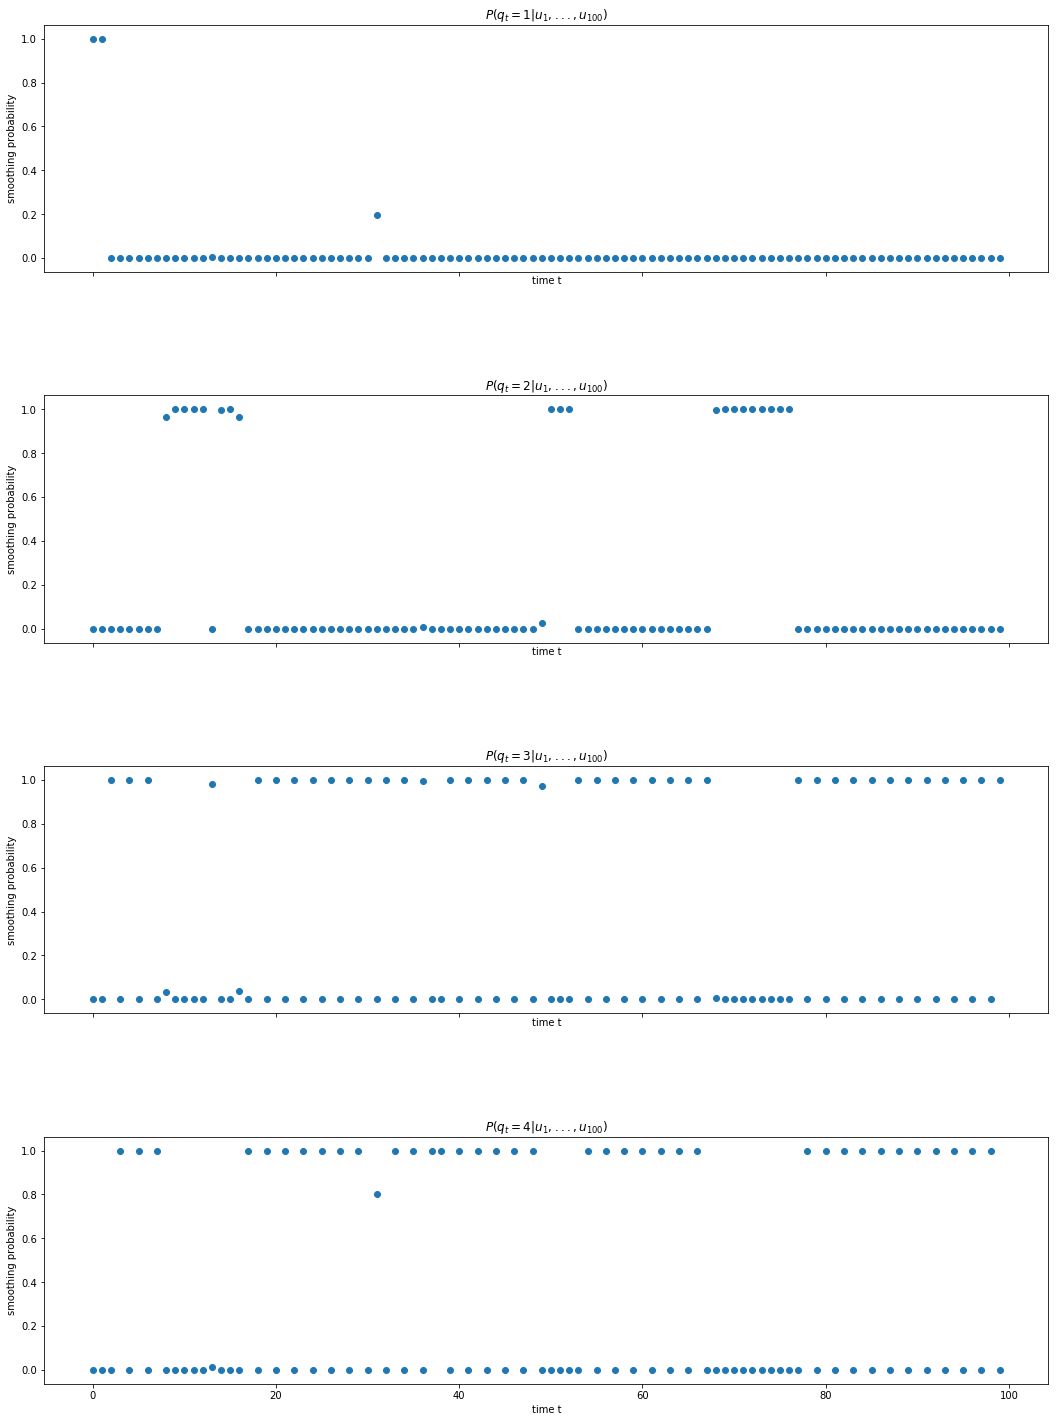

In [34]:
# A_train, pi_train, mu_train, sigma_train
data_test = np.genfromtxt('EMGaussian.test', delimiter=' ')

# reuse parameters learn from HMM to compute smoothing = p[q_t | u_1, ..., u_T]
alpha = logalphaRecursion(data_test, A_train, pi_train, mu_train, sigma_train)
beta = logbetaRecursion(data_test, A_train, pi_train, mu_train, sigma_train)
p_q = smoothing(alpha, beta)

T, d = 100, p_q.shape[1];
f, ax = plt.subplots(d, 1, sharex=True, figsize=(18,25))
f.subplots_adjust(hspace=.5)
for i in range(d):
    ax[i].scatter(np.arange(T), p_q[:T, i])
    ax[i].set_xlabel("time t")
    ax[i].set_ylabel("smoothing probability")
    ax[i].set_title(r'$P(q_t = %d|u_1, ..., u_{100})$' % (i+1))

## Question 10

In [35]:
q_hmm = np.argmax(p_q, axis=1)

def plot_hmm(q):
    T = len(q)
    
    plt.figure(figsize=(25,18))
    plt.grid(True)
    
    plt.scatter(np.arange(T), q + 1, color='black')

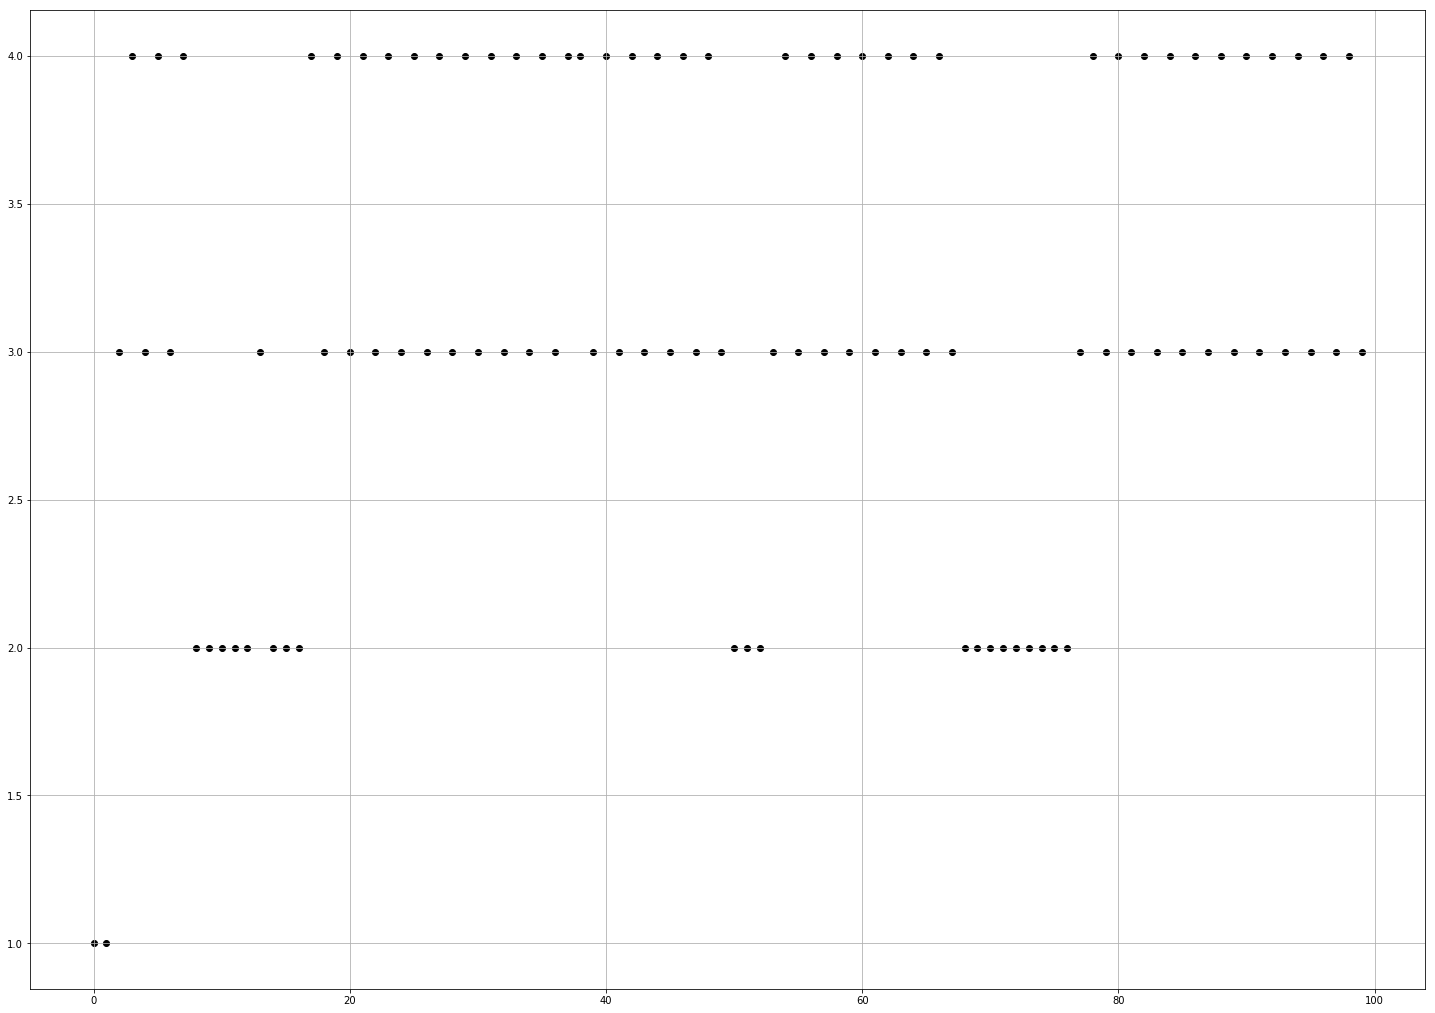

In [36]:
plot_hmm(q_hmm[:100])

## Question 11

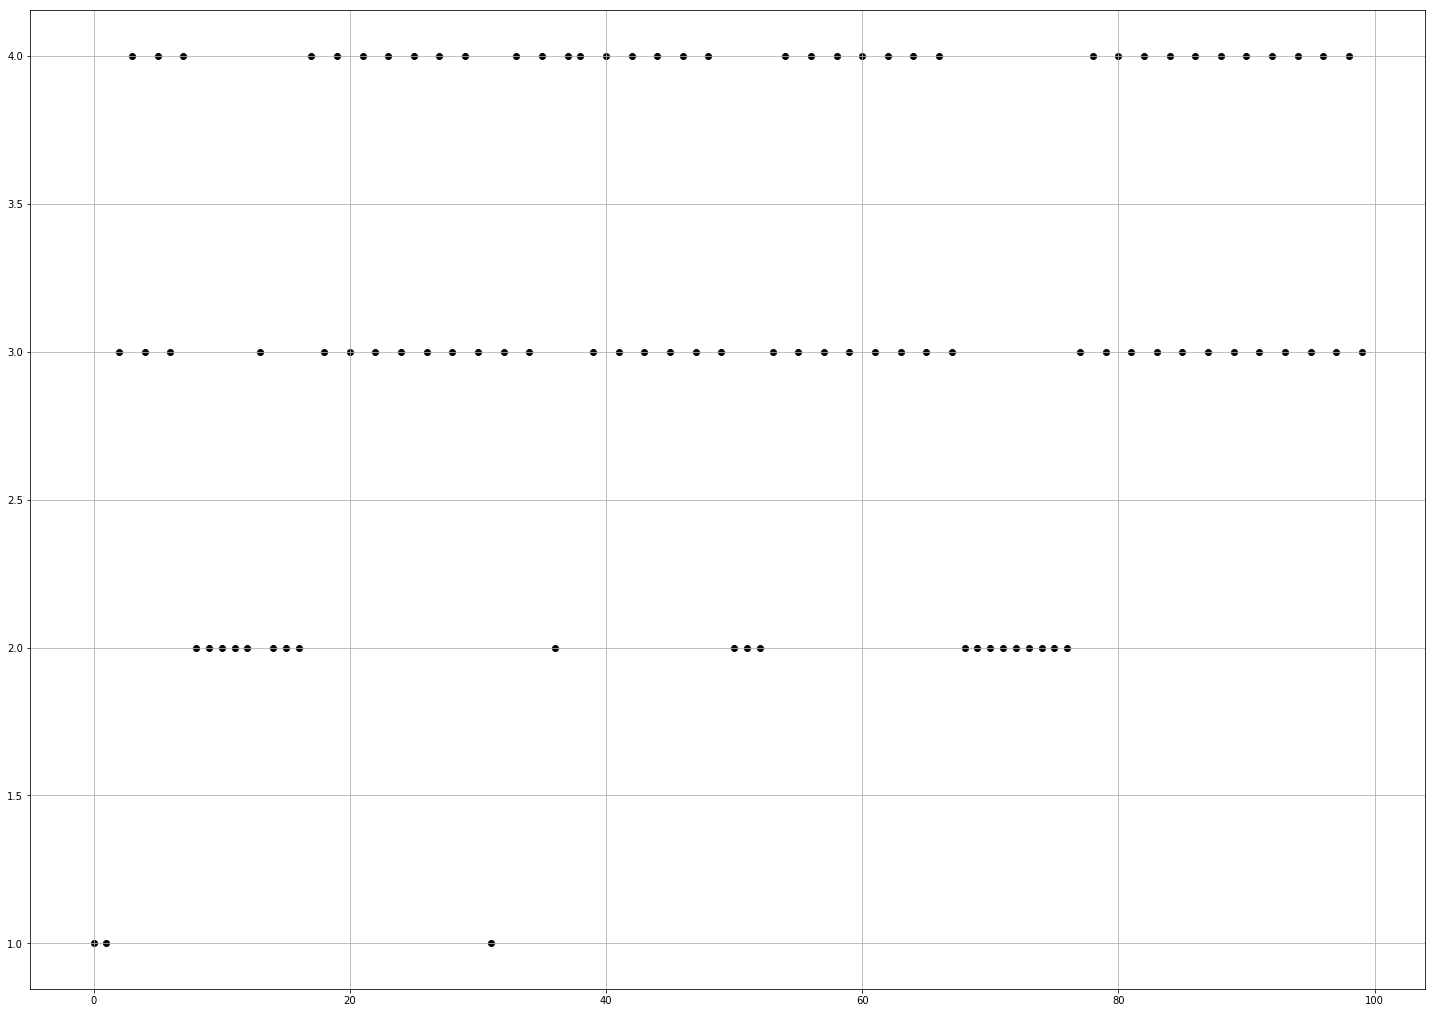

In [37]:
data_test = np.genfromtxt('EMGaussian.test', delimiter=' ')
q_vit_test = viterbi(data_test, A, pi, mu, sigma)
plot_hmm(q_vit_test[:100])

Viterbi algorithm and the previous question associate the same classes to the data points 97 % (485/500) of the time (there is a bug in my viterbi implementation somewhere). Both algorithms should associate the same classes to all the points!

In [38]:
print(r'Same classes using Viterbi algorithm and previous question: %d/%d'
      % (np.sum(q_vit_test == q_hmm), len(q_hmm)))

Same classes using Viterbi algorithm and previous question: 485/500


## Question 12

If the number of states wasn't known I would have choose $K$ (the number of states) that maximize the log-likelihood obtained by the Expectation Maximization algorithm. 